In [1]:
import numpy as np 
import pandas as pd 
import pickle


# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
data_set = 'exp1'
models = ['rmPG', 'caPG', 'ecPG']
method = 'map'
dpi = 300

### Fig. 2A model comparison

/opt/anaconda3/envs/hcl/lib/python3.10/site-packages/seaborn/utils.py:875: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if edgecolor == "face":


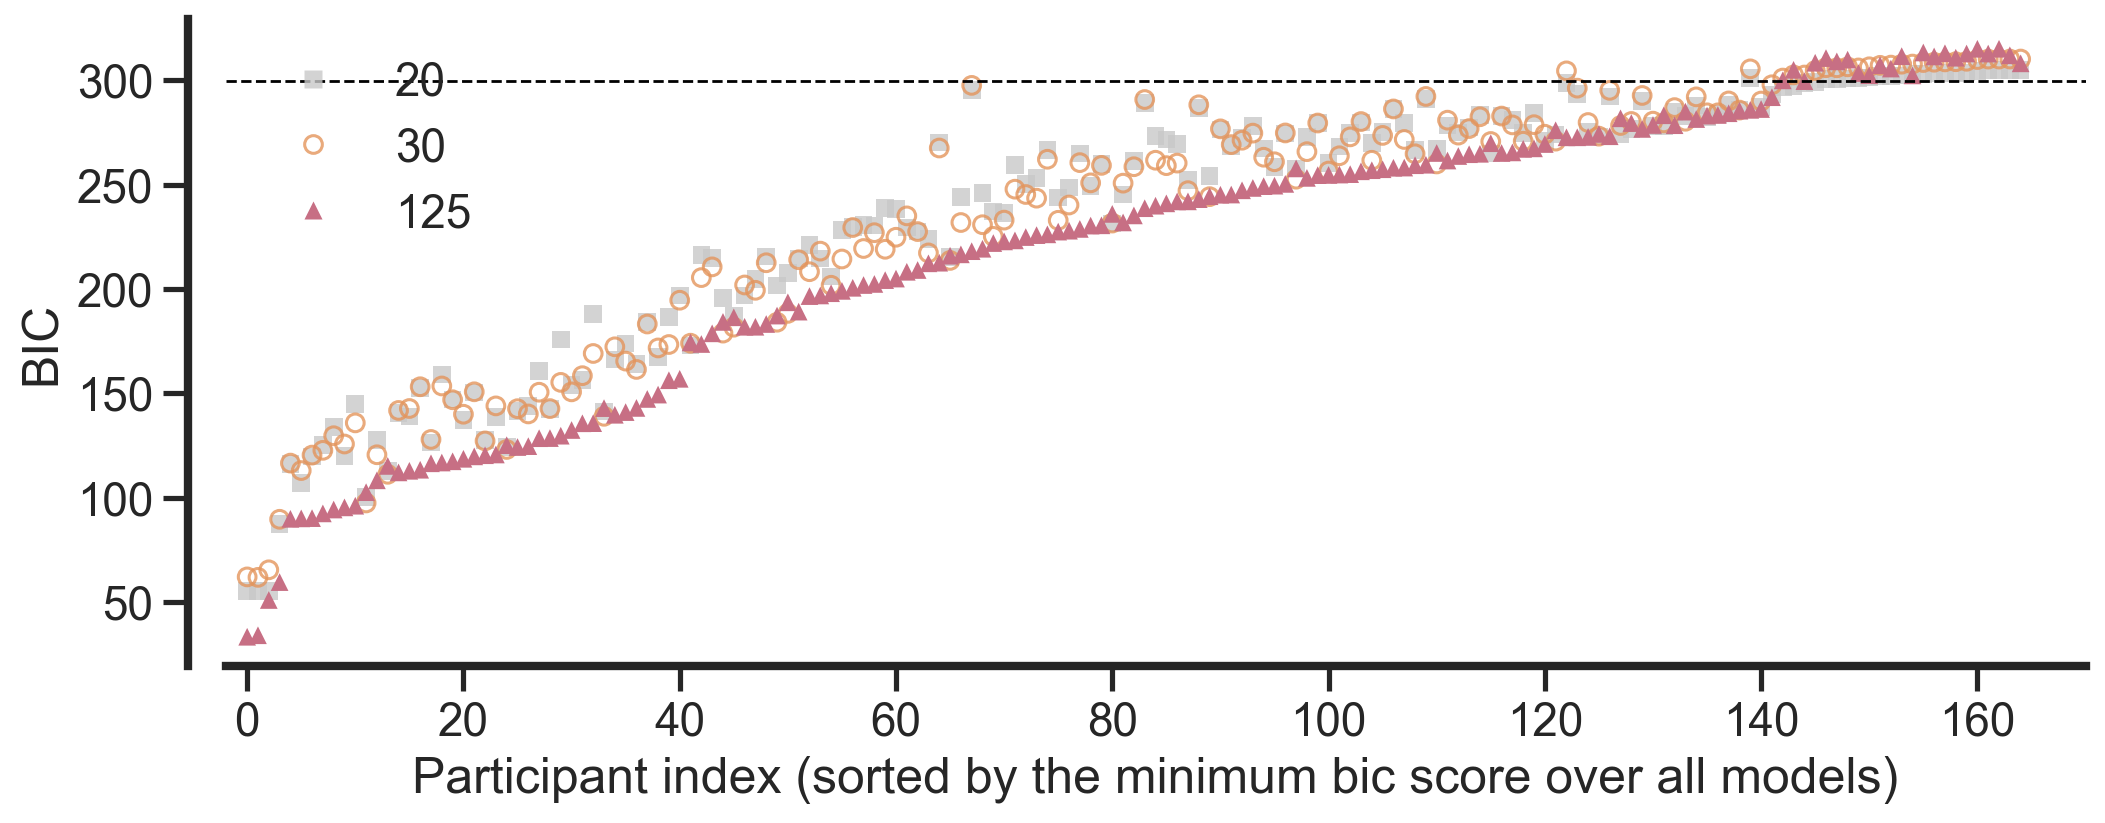

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4.2))
model_compare_per_participant(ax, data_set, models, 
                              method='map', cr='bic', 
                              n_data=2*(60+48))
plt.savefig('../figures/exp1/fIg2A_modelcomp.pdf', dpi=dpi)

In [9]:
def get_crs(data_set, models, method='mle'):
    
    cols = ['tot_nll', 'tot_aic', 'tot_bic', 
            'ass_nll', 'ass_aic', 'ass_bic', 
            'gen_nll', 'gen_aic', 'gen_bic', 
            'agent', 'sub_id']
    mat = {k: [] for k in cols}
    for m in models:
        n_param = eval(m).n_params
        fname = f'../analyses/{data_set}/{m}/{method}-eval.csv'
        data  = pd.read_csv(fname)
        data['nll'] = -data['ll']
        
        group_data = data
        subj_Lst = group_data['sub_id'].unique()
        for sub_id in subj_Lst:
            
            # get subject and model info
            mat['sub_id'].append(sub_id)
            mat['agent'].append(m)

            # for all stage
            inll = group_data.query(f'sub_id=={sub_id}')['nll'].sum() 
            inum = group_data.query(f'sub_id=={sub_id}')['nll'].shape[0]
            mat['tot_nll'].append(inll)
            mat['tot_aic'].append(2*inll + 2*n_param)
            mat['tot_bic'].append(2*inll + np.log(inum)*n_param)

            # for the training stage
            anll = group_data.query(f'sub_id=={sub_id} & stage=="train"'
                                )['nll'].sum() 
            anum = group_data.query(f'sub_id=={sub_id} & stage=="train"'
                                )['nll'].shape[0]
            mat['ass_nll'].append(anll)
            mat['ass_aic'].append(2*anll + 2*n_param)
            mat['ass_bic'].append(2*anll + np.log(anum)*n_param)

            # for the testing stage
            gnll = group_data.query(f'sub_id=={sub_id} & stage=="test"'
                                )['nll'].sum() 
            gnum = group_data.query(f'sub_id=={sub_id} & stage=="test"'
                                )['nll'].shape[0]
            mat['gen_nll'].append(gnll)
            mat['gen_aic'].append(2*gnll + 2*n_param)
            mat['gen_bic'].append(2*gnll + np.log(gnum)*n_param)

    quant_mat = pd.DataFrame.from_dict(mat)
    crs_table = quant_mat.pivot(columns='agent', index='sub_id', 
            values=cols[:-2])
    
    return crs_table

def train_test_corr(crs_table, data_set, models, crs='bic', method='mle'):
    
    sel_table = crs_table[f'tot_{crs}'].copy()
    sel_table[f'min_{crs}'] = sel_table.apply(
        lambda x: np.min([x[m] for m in models]), 
        axis=1)
    sort_table = sel_table.sort_values(by=f'min_{crs}').reset_index()
    sort_table['sub_seq'] = sort_table.index
    # load human performance
    fname = f'{pth}/../analyses/{data_set}/{models[0]}/{method}-eval.csv'
    data  = pd.read_csv(fname)
    # get performance for different period 
    ass_acc  = data.query('group in ["control", "trained"]').groupby(
                        by=['sub_id'])['r'].mean()
    gen_acc  = data.query('group in ["untrained"]').groupby(
                        by=['sub_id'])['r'].mean()
    sort_table = sort_table.merge(ass_acc, on='sub_id'
                        ).rename(columns={'r':'train_acc'})
    sort_table = sort_table.merge(gen_acc, on='sub_id'
                        ).rename(columns={'r':'untrain_acc'})
    print(f'trained:\n{pg.corr(x=sort_table["sub_seq"], y=sort_table["train_acc"])}')
    print(f'untrained:\n{pg.corr(x=sort_table["sub_seq"], y=sort_table["untrain_acc"])}')

    fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.8), sharey=True)
    
    group  = ['Train', 'Untrained']
    colors = [viz.Blue, viz.Blue]
    for i, cr in enumerate(['train', 'untrain']):
        ax=axs[i]
        sns.scatterplot(x='sub_seq', y=f'{cr}_acc', 
                        data=sort_table, alpha=.7,
                        color=colors[i], s=15,
                        edgecolor=colors[i], ax=ax)

        ax.spines['left'].set_position(('axes',-0.05))
        ax.set_xlabel(f'Participant index')
        ax.set_ylabel(f'{group[i]} acc.')
        ax.set_box_aspect(1.3)
    fig.tight_layout()

In [5]:
m = 'ecPG'
fname = f'../fits/{data_set}/fit_sub_info-{m}-{method}.pkl'
with open(fname, 'rb')as handle: fit_sub_info = pickle.load(handle)
sub_lst = list(fit_sub_info.keys())
if 'group' in sub_lst: sub_lst.pop(sub_lst.index('group'))
param_lst = [fit_sub_info[sub_id]['param'] for sub_id in sub_lst]
tmp = np.vstack(param_lst)
p_trans = eval(m).p_trans
param_lst = [fn(tmp[:, i]) for i, fn in enumerate(p_trans)]
param_lst = np.vstack(param_lst).T
p_name = fit_sub_info[sub_lst[0]]['param_name']
p_name = p_name[:-1] if m=='LC' else p_name  
pdata = pd.DataFrame(param_lst, columns=p_name)

In [6]:
import pingouin as pg 
pg.ttest(pdata['λ'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.493459,164,two-sided,0.000613,"[1.48, 5.32]",0.271965,28.384,0.934856


### Fig. 2B PXP

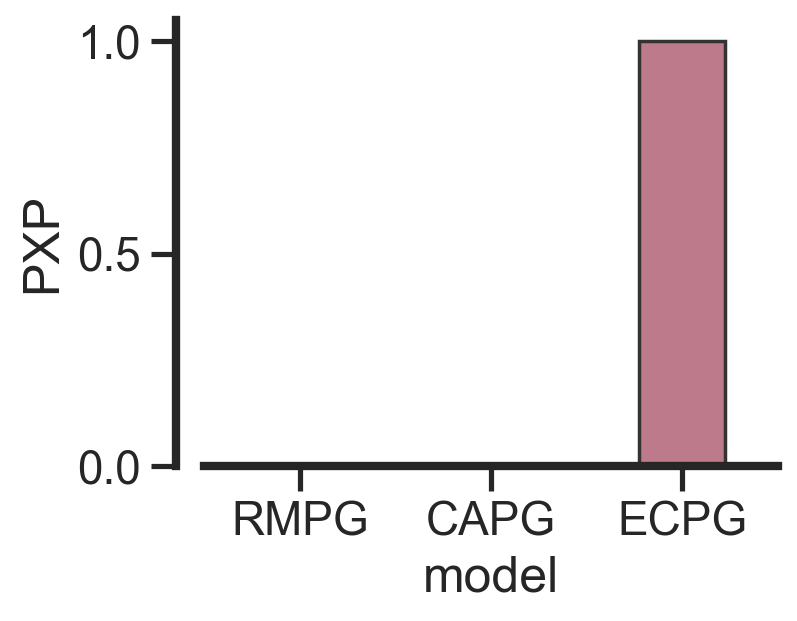

In [18]:
_, pxp = get_llh_score(data_set, models, method=method, 
                        if_bms=True, use_bic=True)
fig, ax = plt.subplots(1, 1, figsize=(3.7, 2.9))
sns.barplot(y='pxp', x='model', data=pxp,
            hue='model', hue_order=models,
            edgecolor=[.2]*3, lw=1.25, width=.45,
            palette=[eval(m).color for m in models])
ax.spines['left'].set_position(('axes',-0.05))
for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(3)
ax.set_xticks(range(len(models)))
ax.set_xticklabels([eval(m).name for m in models])
ax.set_yticks([0, .5, 1.])
ax.set_ylabel('PXP')
plt.savefig(f'../figures/{data_set}/Fig2B_pxp.pdf', dpi=dpi)

### Fig. 2C representation complexity reduction

In [13]:
def viz_reduct(comb_data, agents):
    palette = [eval(agent).color for agent in agents]
    fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.4))
    viz.violin(ax, x='model', order=models, 
               y='iSZ_reduct', data=comb_data,
               errorbar='sd', scatter_size=3,
               palette=palette,)
    ax.legend().remove()
    ax.axhline(y=0, xmin=0, xmax=1, lw=1, 
        color=[.2, .2, .2], ls='--')
    ax.set_ylim([-.7, .3])
    ax.spines['left'].set_position(('axes',-0.05))
    for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
    ax.set_xlabel('')
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([None, None, None])
    ax.set_ylabel('bits reduce')
    ax.set_box_aspect(1.4)
    fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


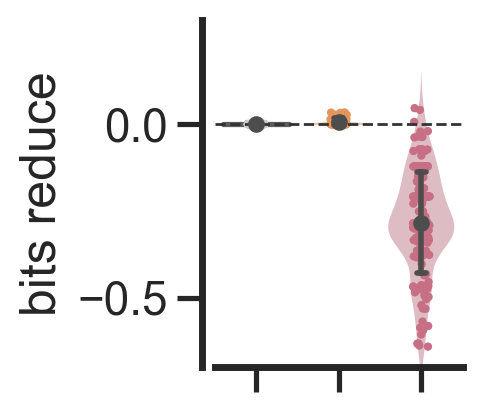

In [14]:
comb_data = iSZ_reduct(data_set, agents=models, method=method)
viz_reduct(comb_data, agents=models)
plt.savefig(f'../figures/{data_set}/Fig2C_reduct.pdf', dpi=dpi)

### Fig. 2D Generalization

In [5]:
def viz_transfer(exp, agents, method='mle'):
    data = []
    for agent in agents:
        df = pd.read_csv(f'{pth}/../analyses/{exp}/{agent}/{method}-base.csv')
        df['agent'] = agent
        data.append(df)
    data = pd.concat(data, axis=0)
    # rename the agent for figures
    fig, ax = plt.subplots(1, 1, figsize=(6.5, 5))
    transfer(ax, data, agents)
    ax.set_yticks([0, .25, .5, .75, 1])
    ax.set_yticklabels([0, None, .5, None, 1])
    fig.tight_layout()

In [3]:
data_set = 'exp1'
models = ['rmPG', 'ecPG']
method = 'map'
dpi = 300

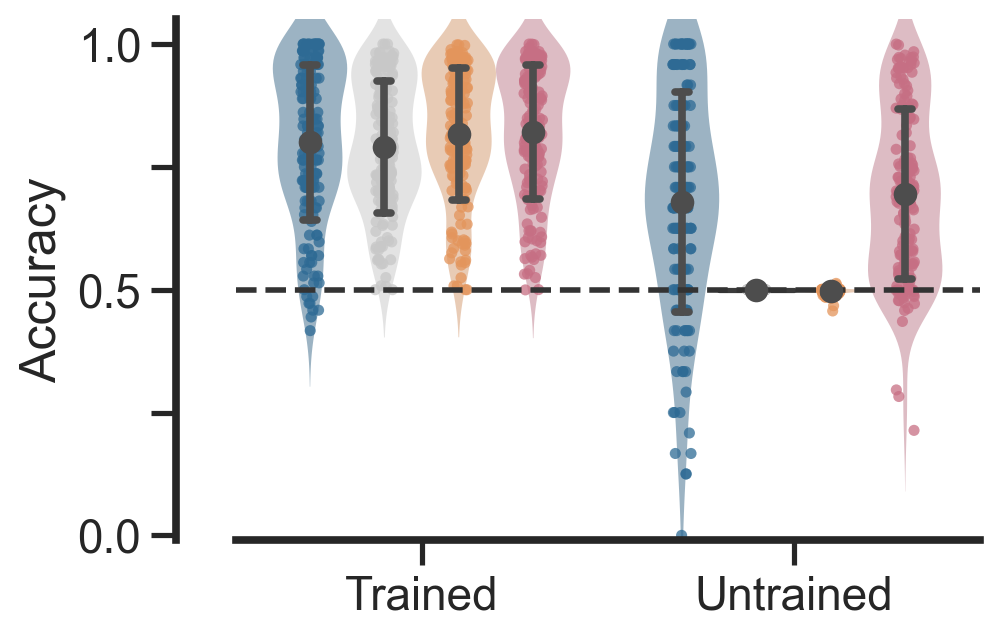

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.5))
generalize_exp1(ax, data_set, ['human']+models)
ax.set_box_aspect(.7)
plt.savefig(f'../figures/{data_set}/Fig2D_transfer.pdf', dpi=dpi)

### Fig. 2E Learning 

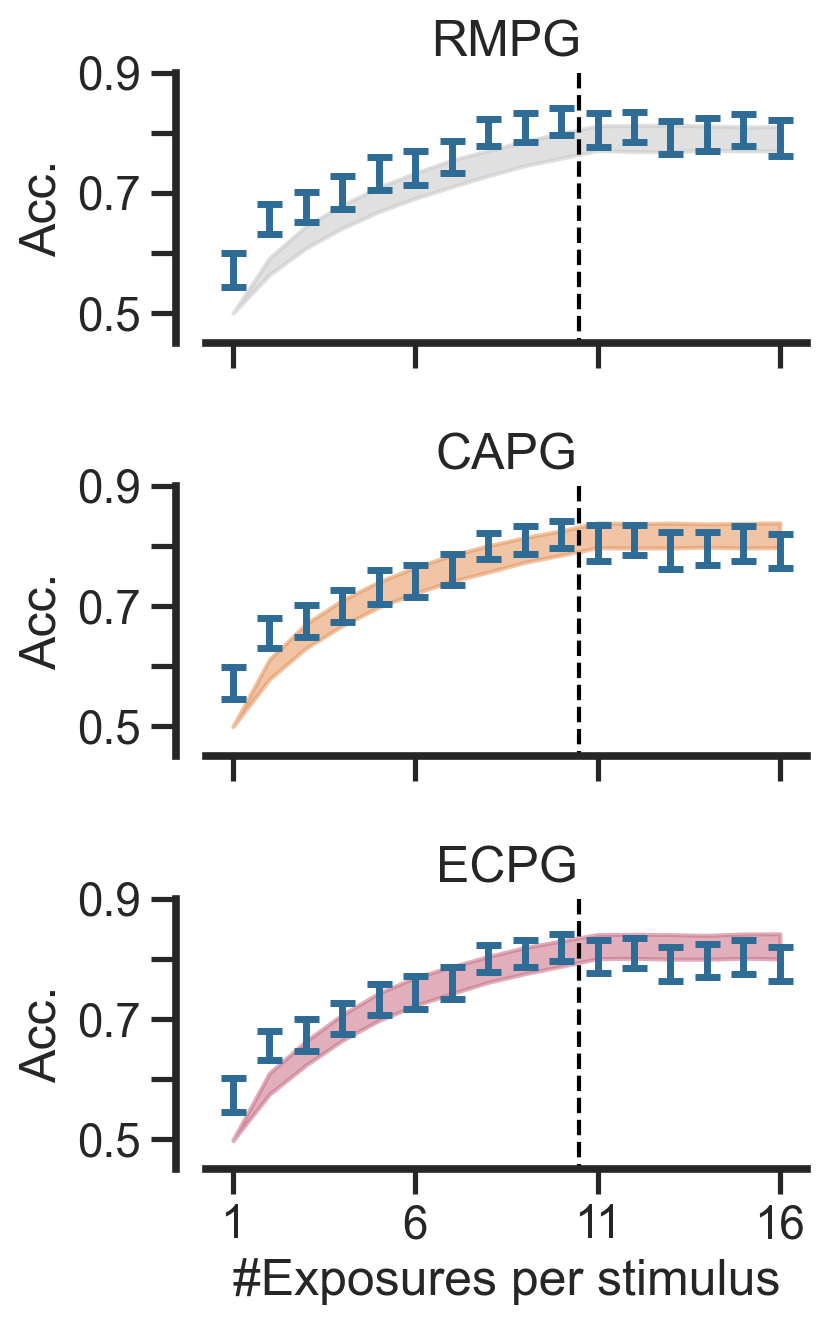

In [11]:
fig, axs = plt.subplots(len(models), 1, figsize=(4.5, 1+len(models)*2), sharex=True)
for i, m in enumerate(models):
    ax = axs[i]
    learning_curve_exp1(ax, get_sim_data('exp1', m, method='map'), 
                color=eval(m).color,
                with_target_data_set='exp1')
    ax.set_box_aspect(.45)
    ax.set_title(eval(m).name)
fig.tight_layout()  
plt.savefig(f'../figures/{data_set}/Fig2E_learning_curves.pdf', dpi=dpi)
    